In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, 'scripts'))

In [2]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

import utils

In [3]:
utils.set_project_dir()

In [4]:
# Directory for figures
fig_dir = 'ml/figures/rf_vs_swat'

In [5]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# colors = ['#1b9e77', '#d95f02', '#7570b3']
colors = ['#e41a1c', '#377eb8', '#4daf4a']
test_size = 0.5
linewidth = 3
fontsize = 32
# markersize = 7
# markeredgewidth = 2
letters = ['A', 'B', 'C', 'D']

# Daily level

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


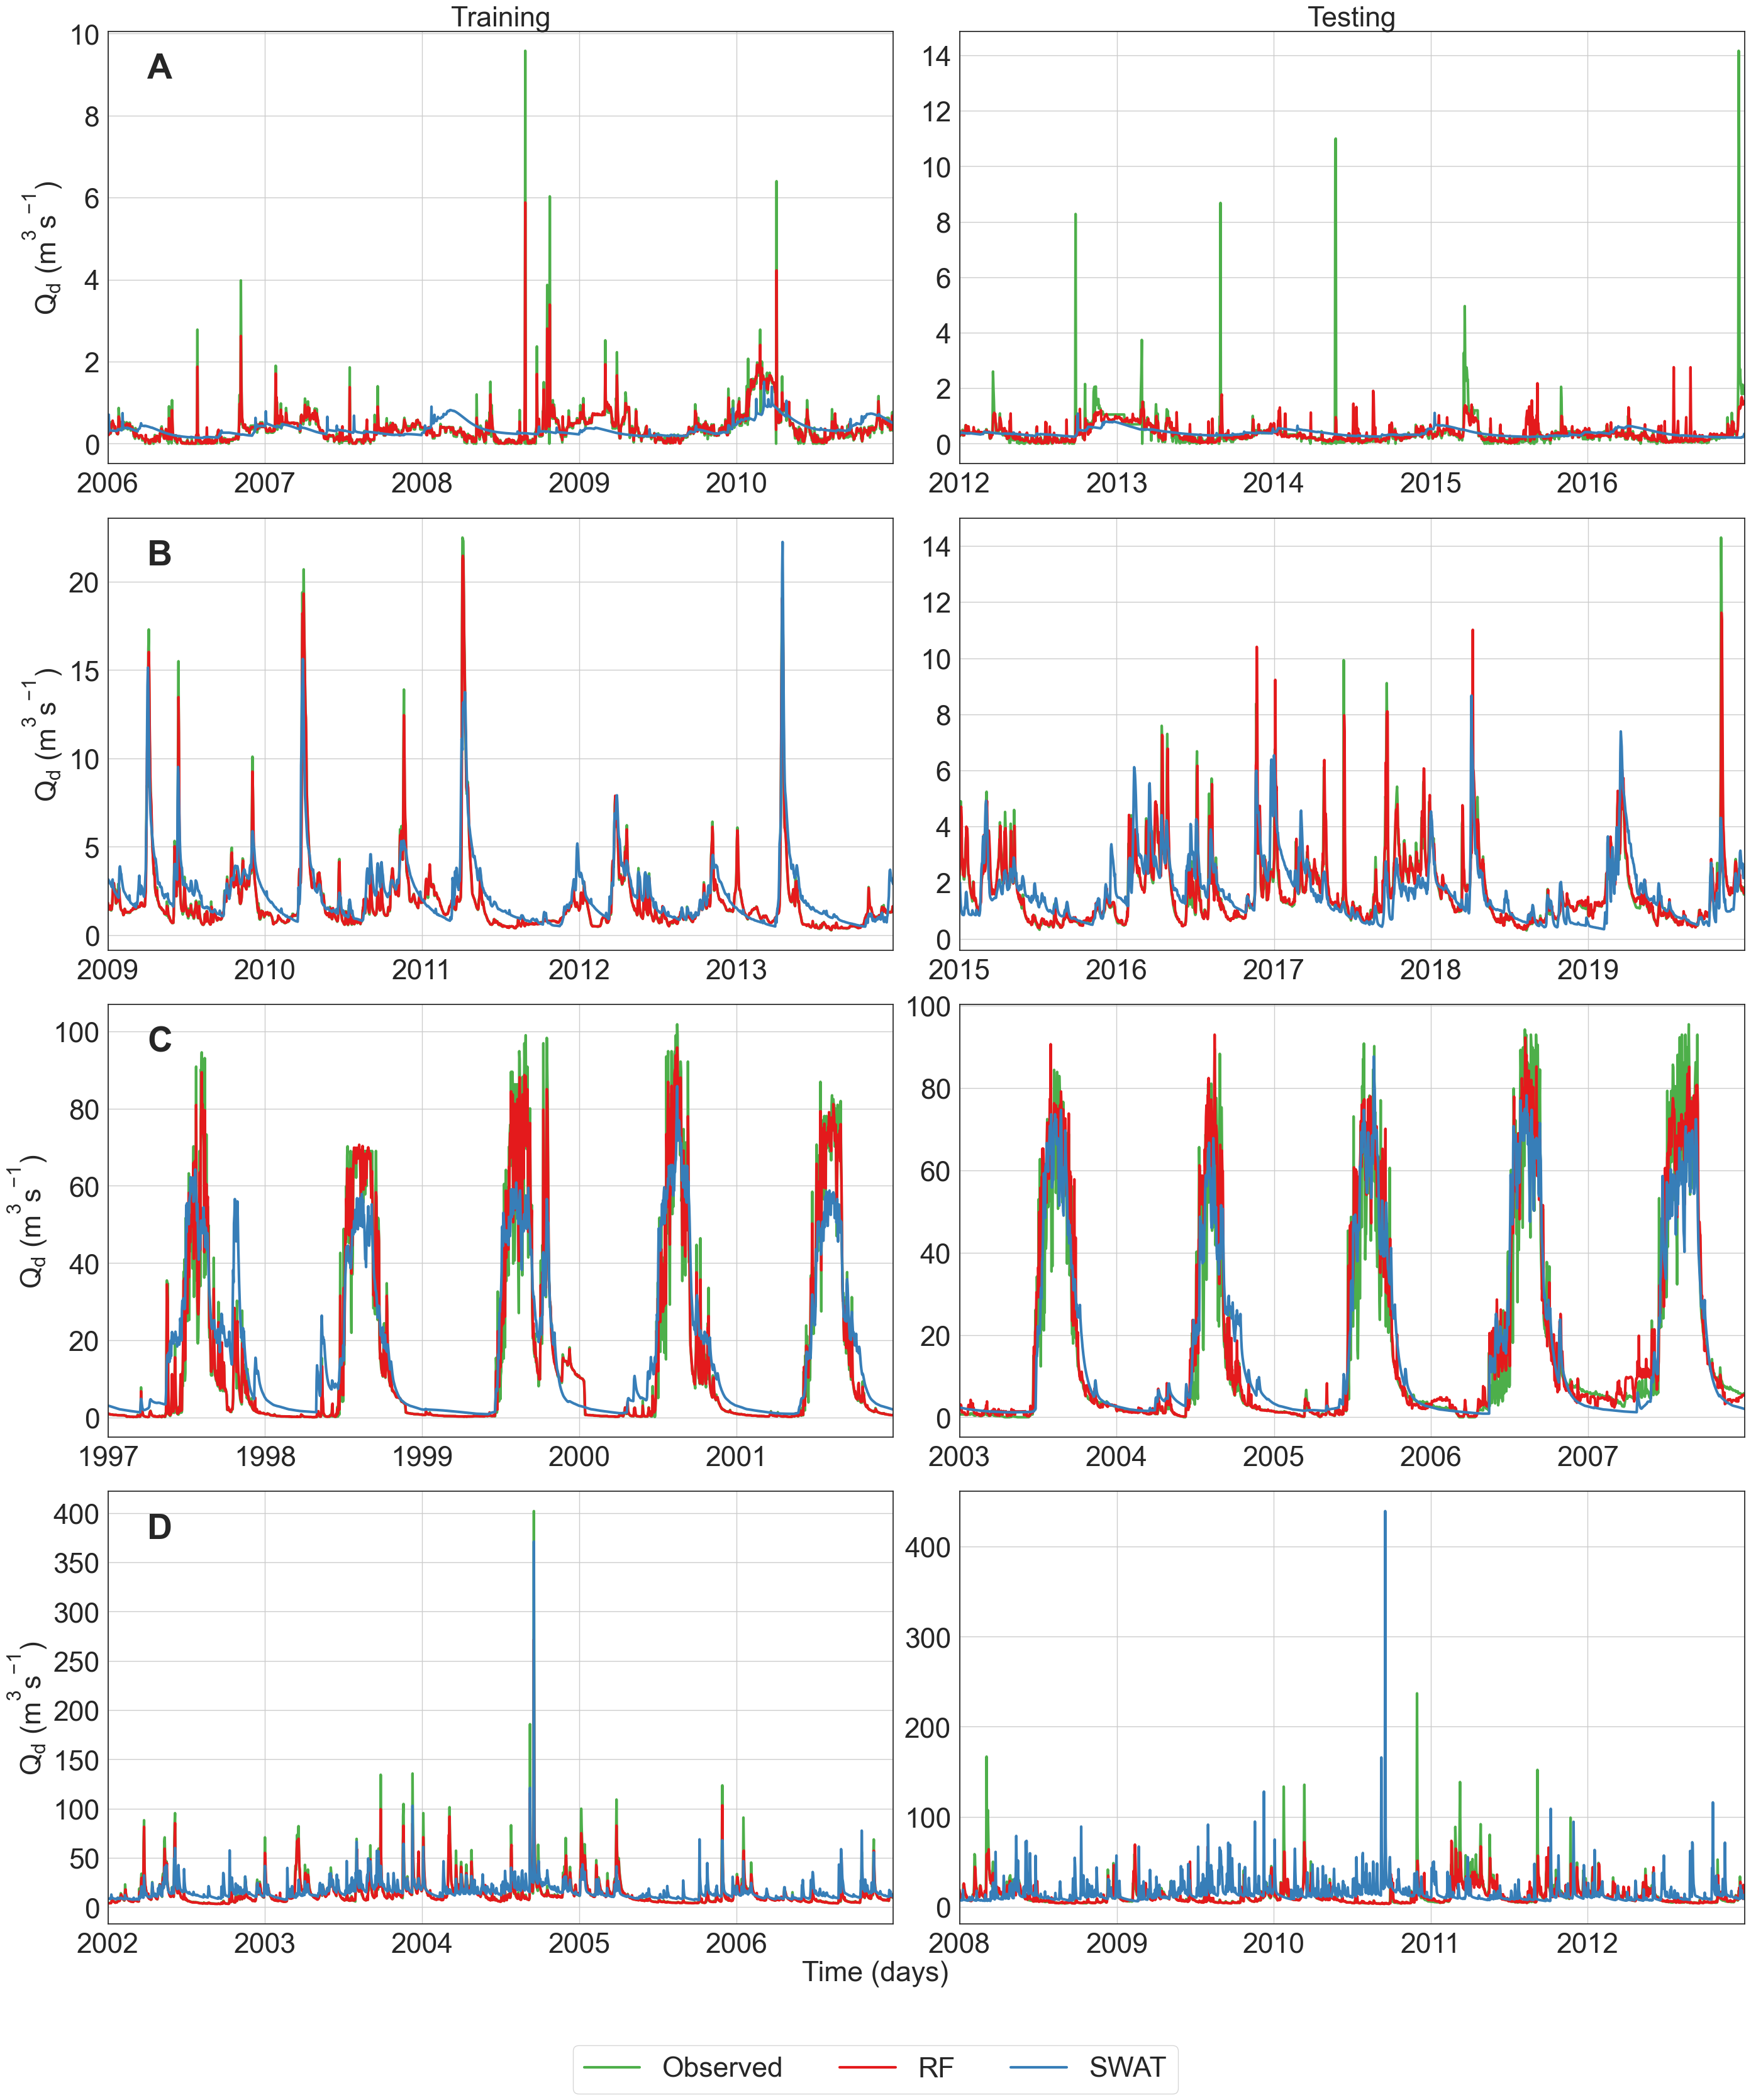

In [6]:
country_codes = ['ESP', 'EST', 'ETH', 'USA']
time_interval = 'd'
target = f'Q_{time_interval}+1'
feat_set = f'FS3_{time_interval}'
test_size = 0.5
test_size_int = int(test_size * 100)

# Read RF metrics
rf_metrics = pd.read_csv(f'ml/{target}_rf_metrics.csv')

with sns.axes_style('white'):
    
    fig, axes = plt.subplots(4, 2, figsize=(28, 32))
    plt.rcParams['axes.grid'] = True
    
    for i in range(len(country_codes)):

        country_code = country_codes[i]
        ax = axes[i]

        # Read SWAT results
        excel_file = 'swat/SWAT_results.xlsx'
        sheet_name = f'{country_code}_{time_interval.upper()}'
        swat_results = pd.read_excel(excel_file, sheet_name=sheet_name)
        swat_results = swat_results.rename(
            columns={swat_results.columns[0]: 'Date', swat_results.columns[1]: 'Observed', swat_results.columns[2]: 'SWAT'}
        )

        # Shift by one day to match with RF time series
        swat_results['SWAT'] = swat_results['SWAT'].shift(-1)
        swat_results['Observed'] = swat_results['Observed'].shift(-1)
        
        # Get SWAT metrics
        swat_nse_cal, swat_nse_val = utils.get_swat_nse(country_code, time_interval)
        swat_nrmse_cal, swat_nrmse_val = utils.get_swat_nrmse(country_code, time_interval)

        model_dir = utils.get_model_dir(country_code, target, feat_set)

        # Get indices of training samples
        train_indices = pd.read_csv(
            f'{model_dir}/{country_code}_{target}_{feat_set}_feat_train_{test_size_int}.csv', usecols=['Index']
        )['Index'].values

        # Get indices of test samples
        test_indices = pd.read_csv(
            f'{model_dir}/{country_code}_{target}_{feat_set}_feat_test_{test_size_int}.csv', usecols=['Index']
        )['Index'].values

        # Read RF results
        obs_vs_pred = pd.read_csv(f'{model_dir}/{country_code}_{target}_{feat_set}_obs_vs_pred_{test_size_int}.csv', parse_dates=['Date'])
        obs_vs_pred['Index'] = obs_vs_pred.index

        # Training set
        start_train, end_train = utils.get_train_period(country_code)
        obs_vs_pred_train = obs_vs_pred.loc[(start_train <= obs_vs_pred['Date']) & (obs_vs_pred['Date'] <= end_train)]
        obs_vs_pred_train = obs_vs_pred_train.merge(swat_results, how='inner', on='Date')
        obs_vs_pred_train = obs_vs_pred_train.set_index('Date')

        # Test set
        start_test, end_test = utils.get_test_period(country_code)
        obs_vs_pred_test = obs_vs_pred.loc[(start_test <= obs_vs_pred['Date']) & (obs_vs_pred['Date'] <= end_test)]
        obs_vs_pred_test = obs_vs_pred_test.merge(swat_results, how='inner', on='Date')
        obs_vs_pred_test = obs_vs_pred_test.set_index('Date')
        
        # Get RF metrics
        rf_metrics = pd.read_csv(f'ml/{target}_rf_metrics.csv')
        rf_nse_train = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nse_train'].values[0], 2
        )
        rf_nse_test = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nse_test'].values[0], 2
        )
        rf_nrmse_train = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nrmse_train'].values[0], 2
        )
        rf_nrmse_test = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nrmse_test'].values[0], 2
        )
        
        # Plot training set
        obs_vs_pred_train[['Observed']].plot(linewidth=linewidth, ax=ax[0], color=colors[2])
        obs_vs_pred_train[[f'{target}_pred']].plot(linewidth=linewidth, ax=ax[0], color=colors[0])
        obs_vs_pred_train[['SWAT']].plot(linewidth=linewidth, ax=ax[0], color=colors[1])
        ax[0].set(xlabel=None)
        # legend_labels = [
        #     'Observed',
        #     f'RF (NSE={rf_nse_train}' + '; ' + f'NRMSE={rf_nrmse_train}%)',
        #     f'SWAT (NSE={swat_nse_cal}' + '; ' + f'NRMSE={swat_nrmse_cal}%)'
        # ]
        # ax[0].legend(legend_labels, fontsize=fontsize, loc='upper right')
        
        # Plot test set
        obs_vs_pred_test[['Observed']].plot(linewidth=linewidth, ax=ax[1], color=colors[2])
        obs_vs_pred_test[[f'{target}_pred']].plot(linewidth=linewidth, ax=ax[1], color=colors[0])
        obs_vs_pred_test[['SWAT']].plot(linewidth=linewidth, ax=ax[1], color=colors[1])
        ax[1].set(xlabel=None)
        # legend_labels = [
        #     'Observed',
        #     f'RF (NSE={rf_nse_test}' + '; ' + f'NRMSE={rf_nrmse_test}%)',
        #     f'SWAT (NSE={swat_nse_val}' + '; ' + f'NRMSE={swat_nrmse_val}%)'
        # ]
        # ax[1].legend(legend_labels, fontsize=fontsize, loc='upper right')

        # Subplot titles
        if i == 0:
            ax[0].set_title('Training', fontsize=fontsize)
            ax[1].set_title('Testing', fontsize=fontsize)
        
        # Fix tick labels
        ax[0].yaxis.set_tick_params(labelbottom=True)
        ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=fontsize)
        ylabel = f"{target.split('_')[0]}$_\mathregular{{{time_interval.lower()}}}$ " + '$\mathregular{(m^{3}s^{-1})}$'
        ax[0].set_ylabel(ylabel, fontsize=fontsize)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=fontsize)
        ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=fontsize)
        ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=fontsize)

        # Global x-axis label
        if time_interval == 'd':
            time_unit = 'days'
        elif time_interval == 'm':
            time_unit = 'months'
        fig.supxlabel(f'Time ({time_unit})', fontsize=fontsize)

        # Add letter to the left corner
        letter = letters[i]
        ax[0].text(0.05, 0.95, letter, ha='left', va='top', transform=ax[0].transAxes, size=40, weight='bold')
        
        # Remove legends from subplots and get handles and labels for the main legend
        handles, labels = ax[1].get_legend_handles_labels()
        ax[0].get_legend().remove()
        ax[1].get_legend().remove()
    
    # Add main legend
    labels = ['Observed', 'RF', 'SWAT']
    plt.figlegend(handles=handles, labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), title_fontsize=fontsize, fontsize=fontsize)

    fig.tight_layout()
    out_fp = f'{fig_dir}/{target}_{feat_set}_rf_vs_swat_{test_size_int}.png'
    plt.savefig(out_fp, dpi=300)

# Monthly level

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


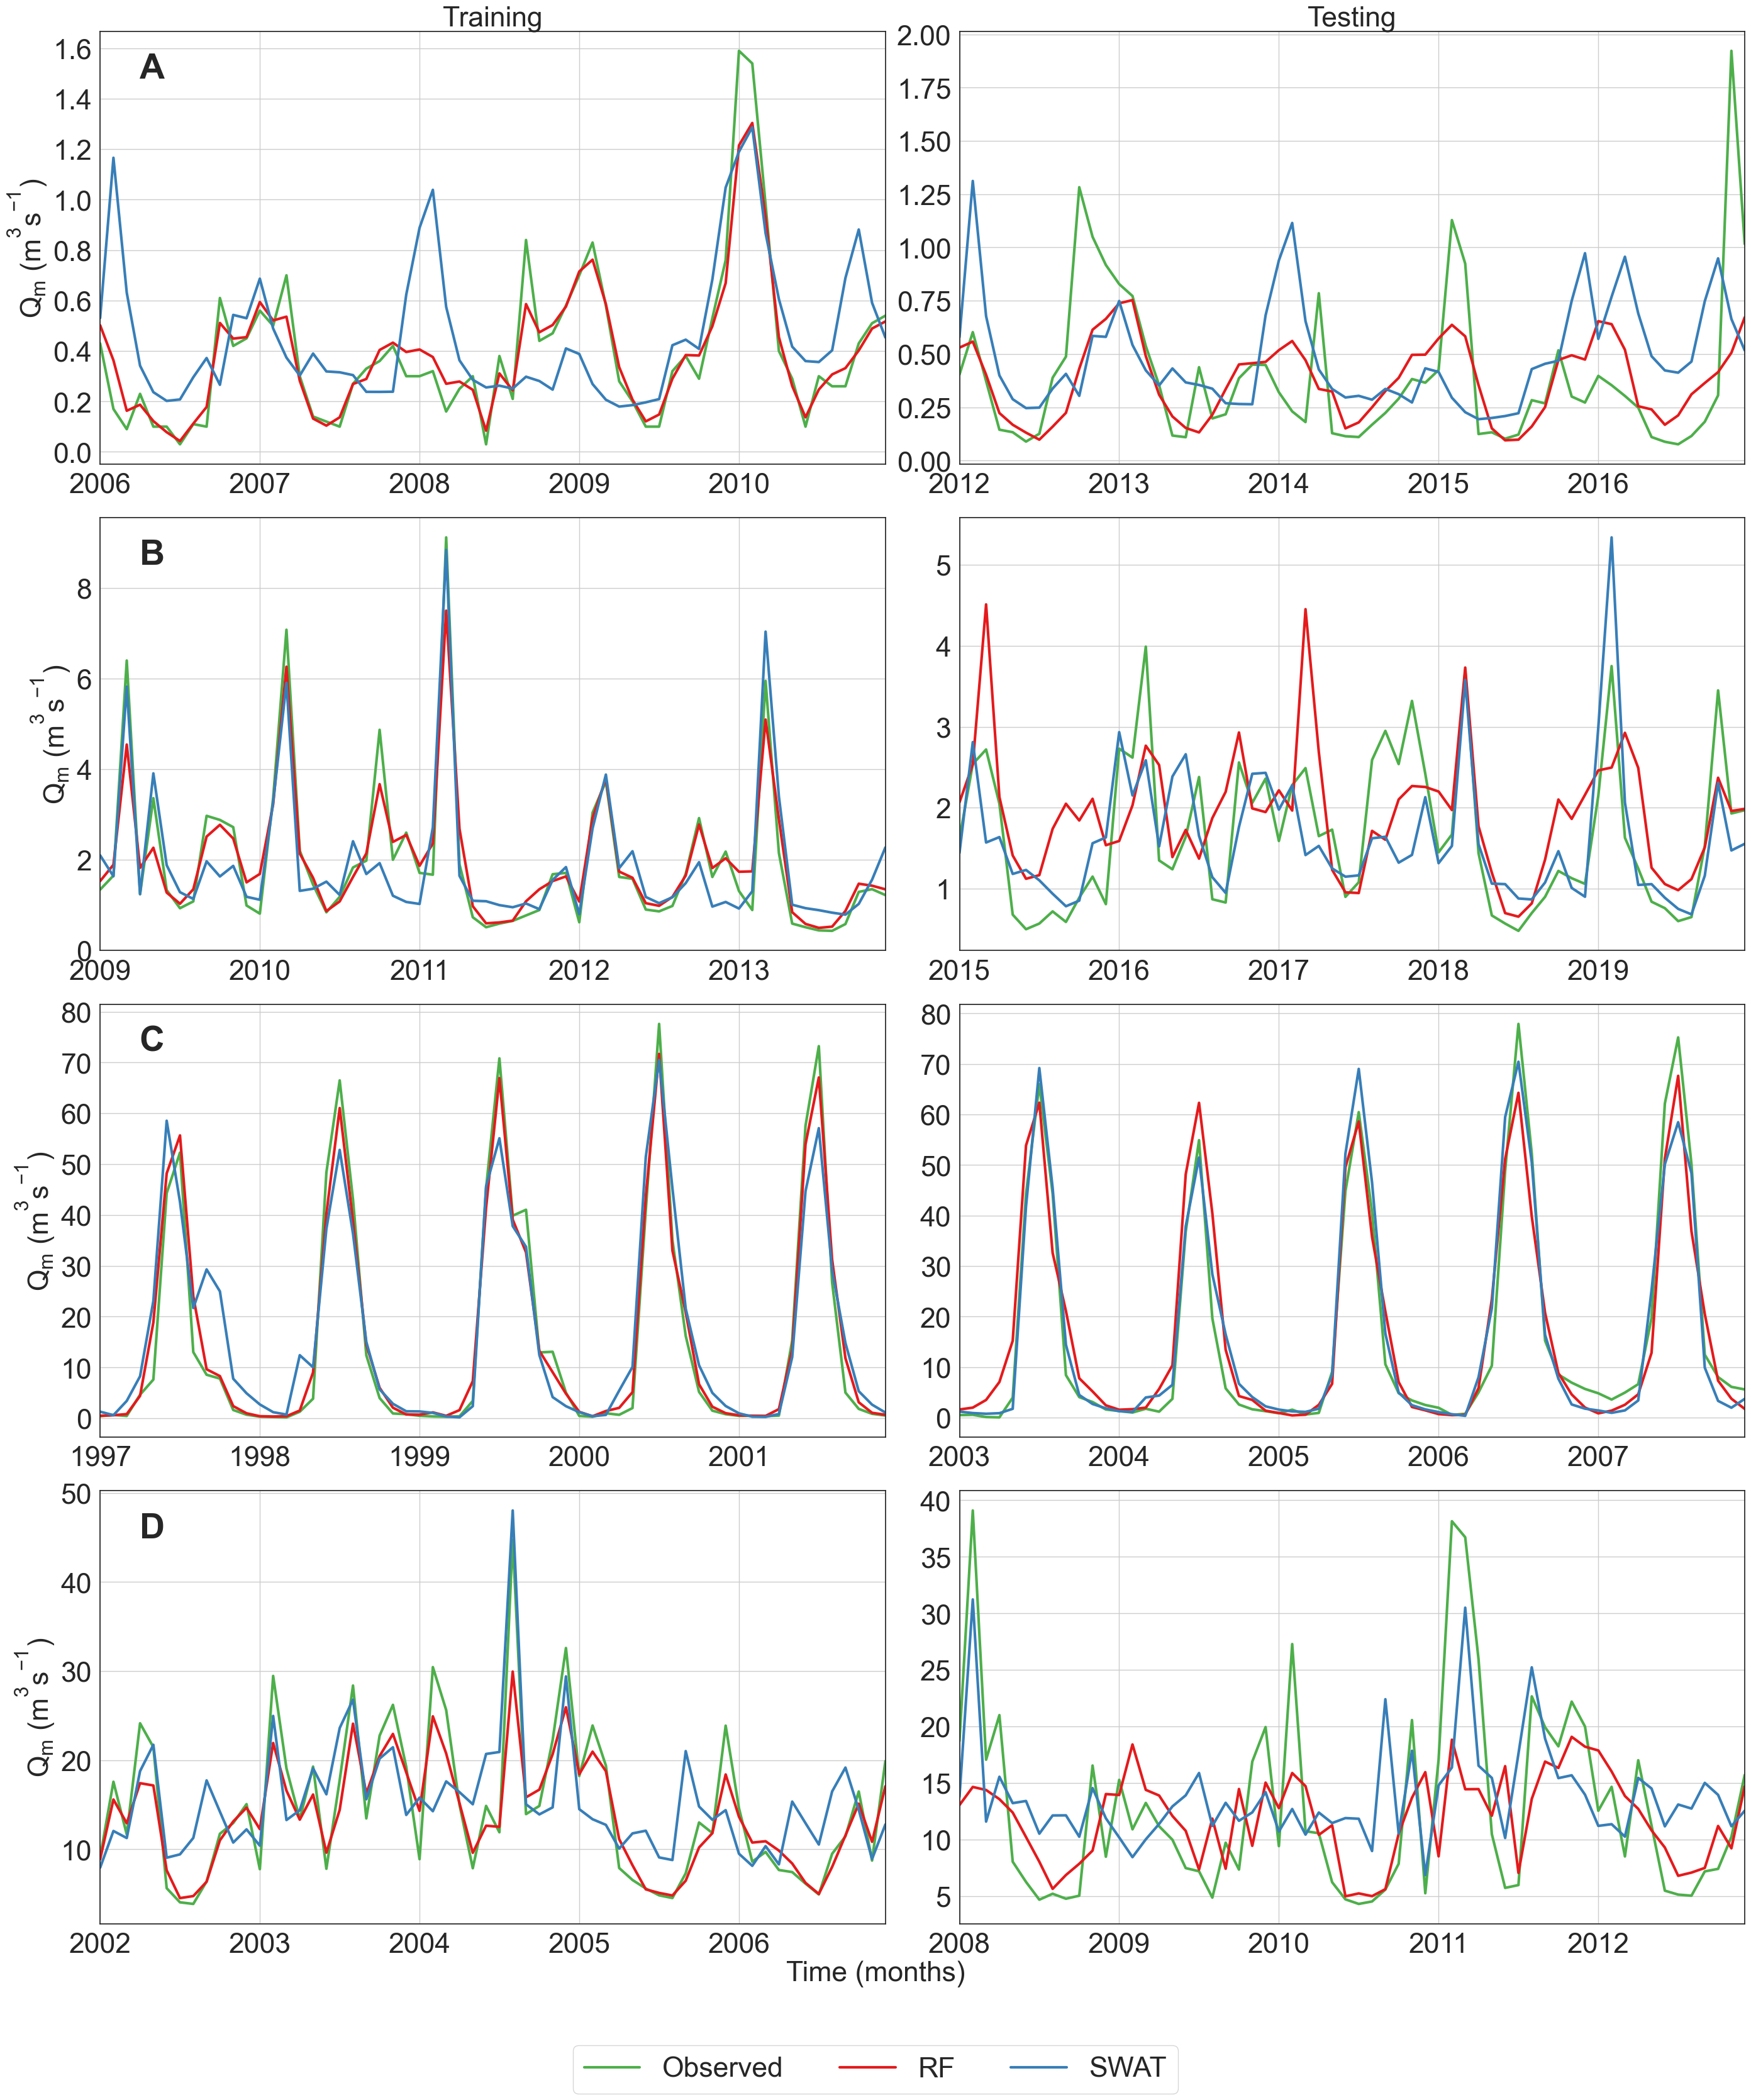

In [7]:
country_codes = ['ESP', 'EST', 'ETH', 'USA']
time_interval = 'm'
target = f'Q_{time_interval}+1'
feat_set = f'FS3_{time_interval}'
test_size = 0.5
test_size_int = int(test_size * 100)

with sns.axes_style('white'):
    
    fig, axes = plt.subplots(4, 2, figsize=(28, 32))
    plt.rcParams['axes.grid'] = True
    
    for i in range(len(country_codes)):

        country_code = country_codes[i]
        ax = axes[i]

        # Read SWAT results
        excel_file = 'swat/SWAT_results.xlsx'
        sheet_name = f'{country_code}_{time_interval.upper()}'
        swat_results = pd.read_excel(excel_file, sheet_name=sheet_name)
        swat_results = swat_results.rename(
            columns={swat_results.columns[0]: 'Date', swat_results.columns[1]: 'Observed', swat_results.columns[2]: 'SWAT'}
        )

        # Shift date to the end of the month to match with RF time series
        swat_results['Date'] = swat_results[swat_results.columns[0]] + pd.offsets.MonthEnd(0)

        # Shift by one month to match with RF time series
        swat_results['SWAT'] = swat_results['SWAT'].shift(-1)
        swat_results['Observed'] = swat_results['Observed'].shift(-1)
        
        # Get SWAT metrics
        swat_nse_cal, swat_nse_val = utils.get_swat_nse(country_code, time_interval)
        swat_nrmse_cal, swat_nrmse_val = utils.get_swat_nrmse(country_code, time_interval)

        model_dir = utils.get_model_dir(country_code, target, feat_set)

        # Get indices of training samples
        train_indices = pd.read_csv(
            f'{model_dir}/{country_code}_{target}_{feat_set}_feat_train_{test_size_int}.csv', usecols=['Index']
        )['Index'].values

        # Get indices of test samples
        test_indices = pd.read_csv(
            f'{model_dir}/{country_code}_{target}_{feat_set}_feat_test_{test_size_int}.csv', usecols=['Index']
        )['Index'].values

        # Read RF results
        obs_vs_pred = pd.read_csv(f'{model_dir}/{country_code}_{target}_{feat_set}_obs_vs_pred_{test_size_int}.csv', parse_dates=['Date'])
        obs_vs_pred['Index'] = obs_vs_pred.index

        # Training set
        start_train, end_train = utils.get_train_period(country_code)
        obs_vs_pred_train = obs_vs_pred.loc[(start_train <= obs_vs_pred['Date']) & (obs_vs_pred['Date'] <= end_train)]
        obs_vs_pred_train = obs_vs_pred_train.merge(swat_results, how='inner', on='Date')
        obs_vs_pred_train = obs_vs_pred_train.set_index('Date')

        # Test set
        start_test, end_test = utils.get_test_period(country_code)
        obs_vs_pred_test = obs_vs_pred.loc[(start_test <= obs_vs_pred['Date']) & (obs_vs_pred['Date'] <= end_test)]
        obs_vs_pred_test = obs_vs_pred_test.merge(swat_results, how='inner', on='Date')
        obs_vs_pred_test = obs_vs_pred_test.set_index('Date')
        
        # Get RF metrics
        rf_metrics = pd.read_csv(f'ml/{target}_rf_metrics.csv')
        rf_nse_train = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nse_train'].values[0], 2
        )
        rf_nse_test = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nse_test'].values[0], 2
        )
        rf_nrmse_train = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nrmse_train'].values[0], 2
        )
        rf_nrmse_test = round(
            rf_metrics[(rf_metrics['country_code'] == country_code) & (rf_metrics['feat_set'] == feat_set)]['nrmse_test'].values[0], 2
        )
        
        # Plot training set
        obs_vs_pred_train[['Observed']].plot(linewidth=linewidth, ax=ax[0], color=colors[2])
        obs_vs_pred_train[[f'{target}_pred']].plot(linewidth=linewidth, ax=ax[0], color=colors[0])
        obs_vs_pred_train[['SWAT']].plot(linewidth=linewidth, ax=ax[0], color=colors[1])
        ax[0].set(xlabel=None)
        # legend_labels = [
        #     'Observed',
        #     f'RF (NSE={rf_nse_train}' + '; ' + f'NRMSE={rf_nrmse_train}%)',
        #     f'SWAT (NSE={swat_nse_cal}' + '; ' + f'NRMSE={swat_nrmse_cal}%)'
        # ]
        # ax[0].legend(legend_labels, fontsize=fontsize, loc='upper right')
        
        # Plot test set
        obs_vs_pred_test[['Observed']].plot(linewidth=linewidth, ax=ax[1], color=colors[2])
        obs_vs_pred_test[[f'{target}_pred']].plot(linewidth=linewidth, ax=ax[1], color=colors[0])
        obs_vs_pred_test[['SWAT']].plot(linewidth=linewidth, ax=ax[1], color=colors[1])
        ax[1].set(xlabel=None)
        # legend_labels = [
        #     'Observed',
        #     f'RF (NSE={rf_nse_test}' + '; ' + f'NRMSE={rf_nrmse_test}%)',
        #     f'SWAT (NSE={swat_nse_val}' + '; ' + f'NRMSE={swat_nrmse_val}%)'
        # ]
        # ax[1].legend(legend_labels, fontsize=fontsize, loc='upper right')

        # Subplot titles
        if i == 0:
            ax[0].set_title('Training', fontsize=fontsize)
            ax[1].set_title('Testing', fontsize=fontsize)
        
        # Fix tick labels
        ax[0].yaxis.set_tick_params(labelbottom=True)
        ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=fontsize)
        ylabel = f"{target.split('_')[0]}$_\mathregular{{{time_interval.lower()}}}$ " + '$\mathregular{(m^{3}s^{-1})}$'
        ax[0].set_ylabel(ylabel, fontsize=fontsize)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=fontsize)
        ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=fontsize)
        ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=fontsize)

        # Global x-axis label
        if time_interval == 'd':
            time_unit = 'days'
        elif time_interval == 'm':
            time_unit = 'months'
        fig.supxlabel(f'Time ({time_unit})', fontsize=fontsize)

        # Add letter to the left corner
        letter = letters[i]
        ax[0].text(0.05, 0.95, letter, ha='left', va='top', transform=ax[0].transAxes, size=40, weight='bold')
        
        # Remove legends from subplots and get handles and labels for the main legend
        handles, labels = ax[1].get_legend_handles_labels()
        ax[0].get_legend().remove()
        ax[1].get_legend().remove()
        
    # Add main legend
    labels = ['Observed', 'RF', 'SWAT']
    plt.figlegend(handles=handles, labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), title_fontsize=fontsize, fontsize=fontsize)
    
    fig.tight_layout()
    out_fp = f'{fig_dir}/{target}_{feat_set}_rf_vs_swat_{test_size_int}.png'
    plt.savefig(out_fp, dpi=300)